In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.display
import os
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.stats import kurtosis, skew


In [2]:
y_train = pd.read_csv("data/Y_train_ofTdMHi.csv")

# 1. EDA

## Analyze the target variable

In [3]:
y_train.head()

,id,pos_label
0,00000-JAM.wav,0.0
1,00001-JAM.wav,1.0
2,00002-JAM.wav,1.0
3,00003-JAM.wav,1.0
4,00004-JAM.wav,1.0


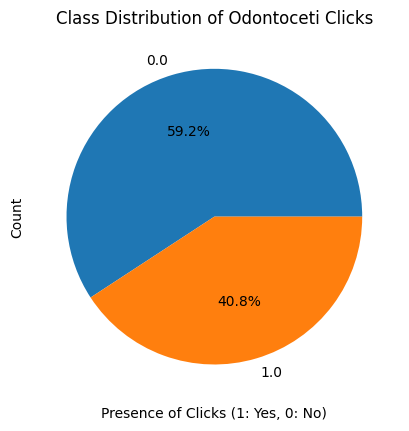

In [4]:
#Visualize the repartition of the target variable 
y_train['pos_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Class Distribution of Odontoceti Clicks")
plt.xlabel("Presence of Clicks (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()


In [5]:
# Extract location information from file names
y_train["location"] = y_train["id"].apply(lambda x: x.split("-")[-1].split(".")[0])

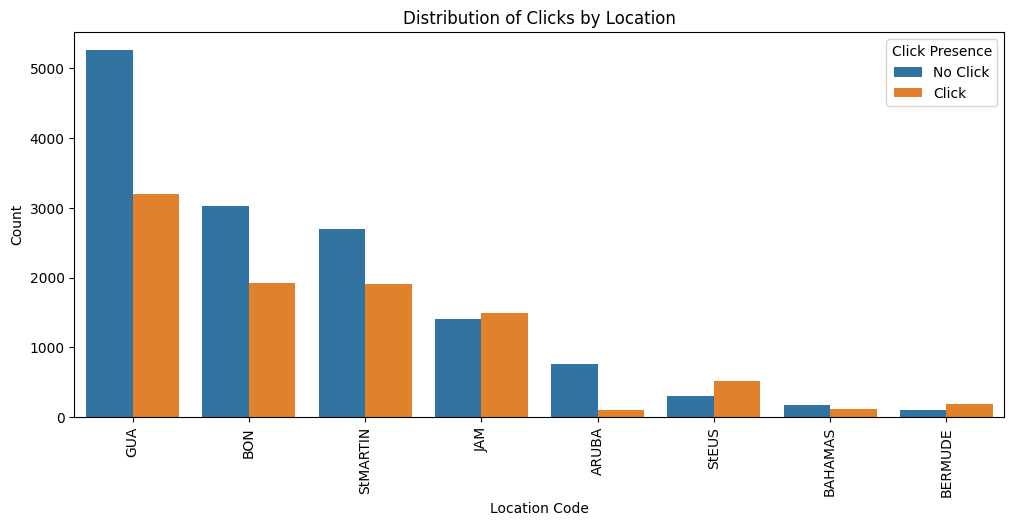

In [6]:
# Location-based distribution plot
plt.figure(figsize=(12, 5))
sns.countplot(x=y_train["location"], hue=y_train["pos_label"], order=y_train["location"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Clicks by Location")
plt.xlabel("Location Code")
plt.ylabel("Count")
plt.legend(title="Click Presence", labels=["No Click", "Click"])
plt.show()

Certain locations may have more odontoceti clicks, indicating regional differences in marine life activity.

## Audio Data Exploration

Nous allons prendre les même variables que le benchmark du challenge pour commencer

In [8]:
# Charger les fichiers audio
audio_files = [os.path.join("data/X_train", f) for f in os.listdir("data/X_train") if f.endswith(".wav")]

audio_properties = []

for file in audio_files:
    y, sr = librosa.load(file, sr=None)  # Charger l'audio avec la fréquence d'échantillonnage originale
    duration = len(y) / sr

    # Amplitude (statistiques)
    amp_mean, amp_std, amp_min, amp_max = np.mean(y), np.std(y), np.min(y), np.max(y)

    # Puissance RMS
    rms = librosa.feature.rms(y=y)
    rms_mean, rms_std, rms_min, rms_max = np.mean(rms), np.std(rms), np.min(rms), np.max(rms)

    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    centroid_mean, centroid_std, centroid_min, centroid_max = np.mean(centroid), np.std(centroid), np.min(centroid), np.max(centroid)

    # Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max = np.mean(bandwidth), np.std(bandwidth), np.min(bandwidth), np.max(bandwidth)

    # Spectral Flatness
    flatness = librosa.feature.spectral_flatness(y=y)
    flatness_mean, flatness_std, flatness_min, flatness_max = np.mean(flatness), np.std(flatness), np.min(flatness), np.max(flatness)

    # FFT pour trouver la fréquence de pic
    D = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    peak_freq = freqs[np.argmax(np.mean(D, axis=1))]

    # Inter-Click Interval (ICI)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    ici_values = np.diff(onset_times)
    mean_ici = np.mean(ici_values) if len(ici_values) > 0 else 0

    # Signal-to-Noise Ratio (SNR)
    signal_power = np.mean(y**2)
    noise_power = np.var(y)
    snr = 10 * np.log10(signal_power / noise_power)

    # Kurtosis & Skewness du spectre
    spec = np.abs(librosa.stft(y))
    spec_mean = np.mean(spec, axis=1)
    kurt = kurtosis(spec_mean)
    skewness = skew(spec_mean)

    # Stocker les propriétés
    audio_properties.append([
        file, sr, duration, peak_freq, mean_ici, snr, kurt, skewness,
        amp_mean, amp_std, amp_min, amp_max,
        rms_mean, rms_std, rms_min, rms_max,
        centroid_mean, centroid_std, centroid_min, centroid_max,
        bandwidth_mean, bandwidth_std, bandwidth_min, bandwidth_max,
        flatness_mean, flatness_std, flatness_min, flatness_max
    ])

# Créer un DataFrame
columns = [
    "File", "Sampling Rate (Hz)", "Duration (s)", "Peak Frequency", "Mean ICI (s)", "SNR (dB)", "Kurtosis", "Skewness",
    "Amplitude Mean", "Amplitude Std", "Amplitude Min", "Amplitude Max",
    "RMS Mean", "RMS Std", "RMS Min", "RMS Max",
    "Spectral Centroid Mean", "Spectral Centroid Std", "Spectral Centroid Min", "Spectral Centroid Max",
    "Spectral Bandwidth Mean", "Spectral Bandwidth Std", "Spectral Bandwidth Min", "Spectral Bandwidth Max",
    "Spectral Flatness Mean", "Spectral Flatness Std", "Spectral Flatness Min", "Spectral Flatness Max"
]

audio_df = pd.DataFrame(audio_properties, columns=columns)


/Users/maro/projet_dl/venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


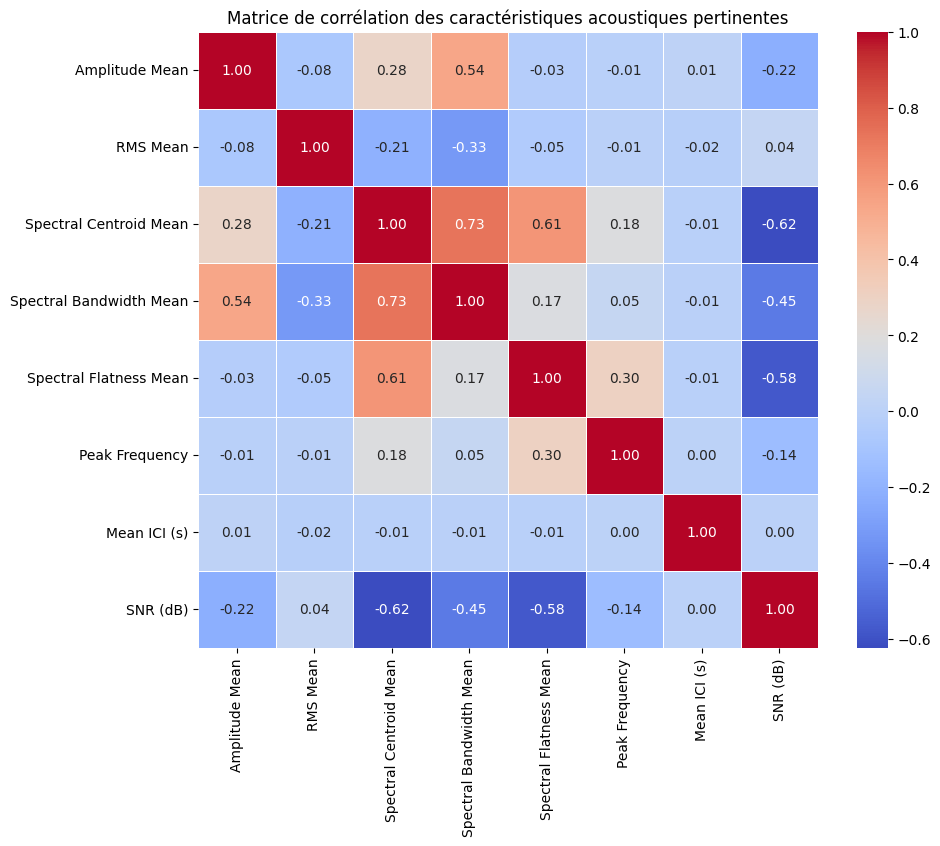

In [9]:
# On garde que les mean pour l'analyse car sinon trop de répétition
selected_features = [
    "Amplitude Mean", "RMS Mean", "Spectral Centroid Mean", 
    "Spectral Bandwidth Mean", "Spectral Flatness Mean", "Peak Frequency",
    "Mean ICI (s)", "SNR (dB)"
]


corr_matrix = audio_df[selected_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation des caractéristiques acoustiques pertinentes")
plt.show()


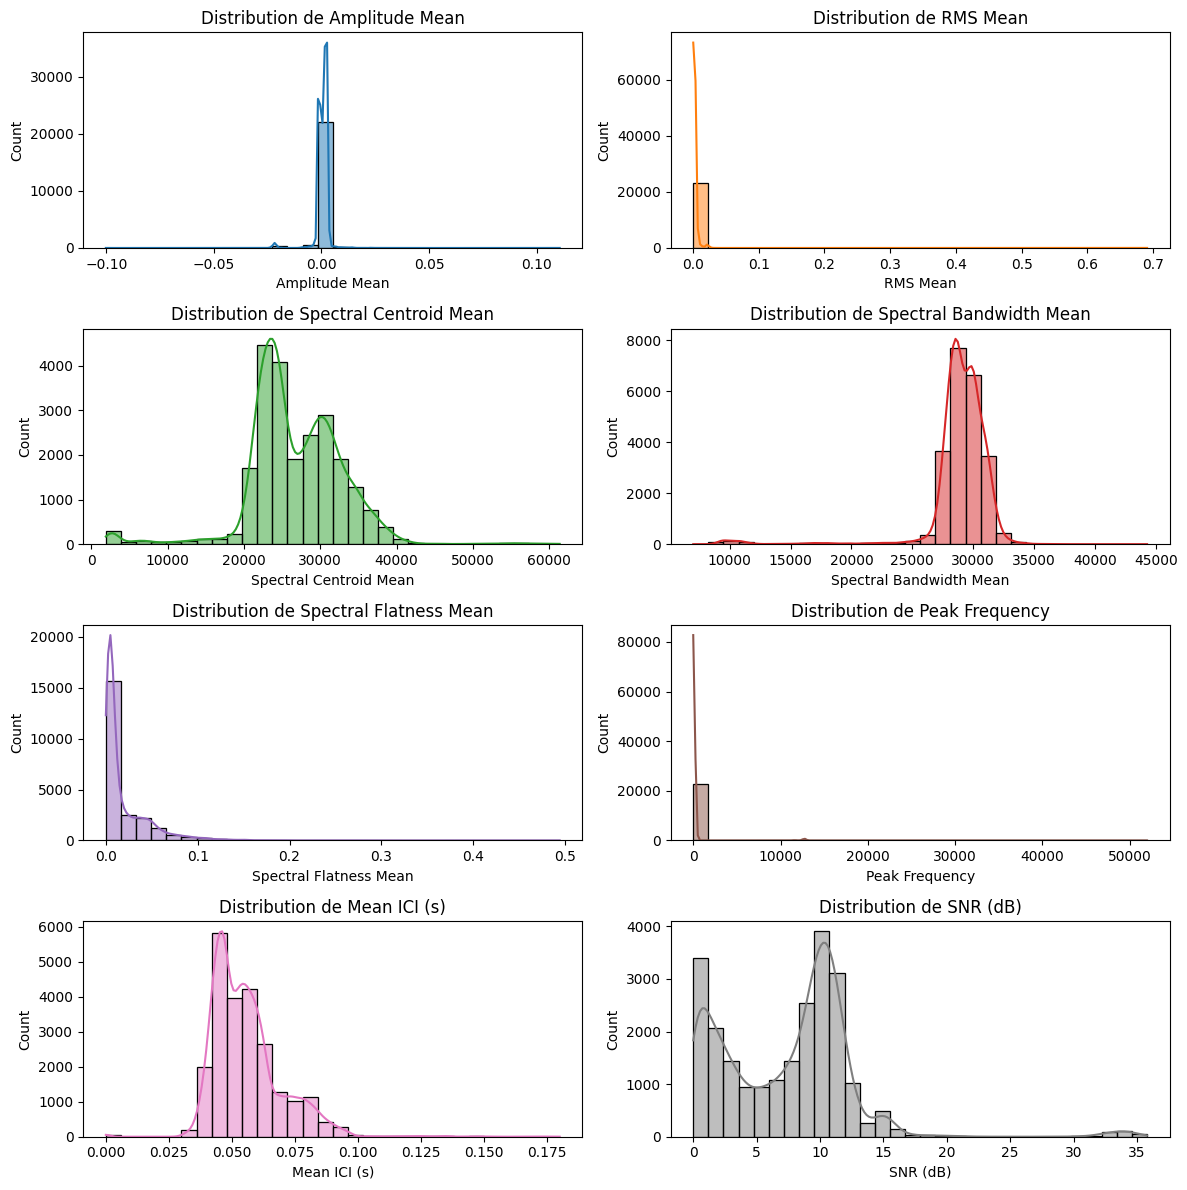

In [20]:
feature_pairs = [
    ("Amplitude Mean", "RMS Mean"),
    ("Spectral Centroid Mean", "Spectral Bandwidth Mean"),
    ("Spectral Flatness Mean", "Peak Frequency"),
    ("Mean ICI (s)", "SNR (dB)")
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

fig, axes = plt.subplots(4, 2, figsize=(12, 12))

# Boucle 
for i, (feature1, feature2) in enumerate(feature_pairs):
    sns.histplot(audio_df[feature1], kde=True, bins=30, color=colors[2*i], ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution de {feature1}")

    sns.histplot(audio_df[feature2], kde=True, bins=30, color=colors[2*i+1], ax=axes[i, 1])
    axes[i, 1].set_title(f"Distribution de {feature2}")

plt.tight_layout()
plt.show()


In [21]:
# On va récupérer la target de la dataframe y_train
audio_df['File'] = audio_df['File'].str.split('/').str[-1]
audio_data = pd.merge(audio_df, y_train, left_on='File', right_on='id', how='inner')

In [22]:
audio_data

,File,Sampling Rate (Hz),Duration (s),Peak Frequency,Mean ICI (s),SNR (dB),Kurtosis,Skewness,Amplitude Mean,Amplitude Std,...,Spectral Bandwidth Std,Spectral Bandwidth Min,Spectral Bandwidth Max,Spectral Flatness Mean,Spectral Flatness Std,Spectral Flatness Min,Spectral Flatness Max,id,pos_label,location
0,09053-StMARTIN.wav,256000,0.2,0.0,0.061333,5.917606,637.376038,24.178423,0.001516,0.000889,...,1856.445460,26283.129677,34609.531409,0.026990,0.030033,0.005673,0.181438,09053-StMARTIN.wav,1.0,StMARTIN
1,03617-StMARTIN.wav,256000,0.2,0.0,0.064000,5.248095,568.235229,22.366589,0.000939,0.000613,...,1812.133145,22773.206853,33808.041229,0.019188,0.008159,0.007842,0.051161,03617-StMARTIN.wav,0.0,StMARTIN
2,13702-GUA.wav,256000,0.2,0.0,0.046500,8.178938,650.869080,24.622904,0.001440,0.000610,...,1552.853267,27371.481394,35056.916436,0.011727,0.020408,0.001645,0.103085,13702-GUA.wav,1.0,GUA
3,02317-StMARTIN.wav,256000,0.2,0.0,0.048500,3.380404,473.605042,19.853598,0.000640,0.000589,...,1557.783701,27539.355304,36475.940302,0.040512,0.027412,0.013578,0.150693,02317-StMARTIN.wav,0.0,StMARTIN
4,08553-StMARTIN.wav,256000,0.2,0.0,0.050667,8.017726,646.328796,24.482790,0.001549,0.000671,...,891.815777,28182.790293,33287.221532,0.013907,0.013774,0.004108,0.063531,08553-StMARTIN.wav,1.0,StMARTIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23163,16508-GUA.wav,256000,0.2,0.0,0.062667,6.168395,631.706482,24.117807,0.001202,0.000678,...,1288.351274,25552.272761,31801.069936,0.008324,0.009093,0.001233,0.047187,16508-GUA.wav,0.0,GUA
23164,04169-GUA.wav,256000,0.2,0.0,0.046500,10.865595,664.027649,24.952465,0.002354,0.000703,...,1560.755661,23615.506262,32525.013724,0.003853,0.001960,0.001747,0.012941,04169-GUA.wav,0.0,GUA
23165,08560-StMARTIN.wav,256000,0.2,0.0,0.039500,2.297717,413.782867,18.162872,0.000546,0.000654,...,1262.083993,27692.994720,35075.995414,0.056428,0.035756,0.017179,0.215662,08560-StMARTIN.wav,1.0,StMARTIN
23166,07681-BON.wav,256000,0.2,0.0,0.048667,3.420752,654.979614,24.734089,-0.001312,0.001199,...,1378.645390,26713.999549,35366.773565,0.010693,0.037733,0.001356,0.238532,07681-BON.wav,1.0,BON
